<a href="https://colab.research.google.com/github/PietroDF/Computer_vision/blob/master/CNN_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN_Segmentation with Keras

Inspiring tutorial @ https://www.tensorflow.org/tutorials/images/segmentation 

Original Dataset @ https://www.robots.ox.ac.uk/~vgg/data/pets/

# Mount Drive

In [0]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# Import Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import keras

# Download the complete dataset

In [0]:
!mkdir '/content/dataset_directory'

## Image folder

In [0]:
!wget --no-check-certificate \
    https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz \
    -O /content/dataset_directory/image_dataset.tar.gz

--2020-03-31 10:01:42--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/x-gzip]
Saving to: ‘/content/dataset_directory/image_dataset.tar.gz’

/content/dataset_di 100%[===================>] 755.23M  31.4MB/s    in 25s     

2020-03-31 10:02:07 (30.8 MB/s) - ‘/content/dataset_directory/image_dataset.tar.gz’ saved [791918971/791918971]



## Label folder

The following annotations are available for every image in the dataset: 

* (a) species and breed name; 
* (b) a tight bounding box (ROI) around the head of the animal; 
* (c) a pixel level foreground-background segmentation (Trimap). 

In [0]:
!wget --no-check-certificate \
    https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz \
    -O /content/dataset_directory/label_dataset.tar.gz

--2020-03-31 10:03:44--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘/content/dataset_directory/label_dataset.tar.gz’

/content/dataset_di 100%[===================>]  18.28M  15.9MB/s    in 1.2s    

2020-03-31 10:03:46 (15.9 MB/s) - ‘/content/dataset_directory/label_dataset.tar.gz’ saved [19173078/19173078]



## Unzip files in folders

In [0]:
import tarfile

In [0]:
with tarfile.open('/content/dataset_directory/image_dataset.tar.gz', 'r:gz') as tar:
    tar.extractall(path='/content/dataset_directory')

In [0]:
with tarfile.open('/content/dataset_directory/label_dataset.tar.gz', 'r:gz') as tar:
    tar.extractall(path='/content/dataset_directory')

## Remove downloaded zip folders

In [0]:
# Image dataset
!rm /content/dataset_directory/image_dataset.tar.gz

# Label dataset
!rm /content/dataset_directory/label_dataset.tar.gz

# Prepare dataset

In [0]:
import os

## List all files in folder

In [0]:
# Directory with our images
image_dir = '/content/dataset_directory/images'
image_names = os.listdir(image_dir)

# remove images if not jpg
image_names = [x for x in image_names if x.split('.')[1]=='jpg']

# Directory with our labels
label_dir = '/content/dataset_directory/annotations/trimaps'

## Store data in numpy array

In [0]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [0]:
num_img_2take = 2000

num_img_2take = np.min([num_img_2take, len(image_names)])

# standardizzo le dimensioni di tutte le immagini
img_dimension = 80

# definisco le liste che conterranno le immagini
x_train = []
y_train = []

# carico tutte le immagini
for img in image_names[:num_img_2take]:

  # costruisco i path
  img_path = image_dir+'/'+img
  lbl_path = label_dir+'/'+img.split('.')[0]+'.png'

  # carico le immagini e le trasformo in formto conveniente
  img = image.load_img(img_path, target_size=(img_dimension,img_dimension))
  img = image.img_to_array(img).astype('uint') #unsigned integer (non necessario)

  # carico le imamgini etichetta e trasformo in formato conveniente
  lbl = image.load_img(lbl_path, target_size=(img_dimension,img_dimension))
  lbl = image.img_to_array(lbl).astype('uint') #unsigned integer (non necessario)

  # NOTA BENE: lbl contiene 3 canali RGB uguali, ciascuno con valori da 1 a 3,
  # li riporto da 0 a 2 per eseguire one-hot encoding con successo
  
  lbl = lbl - 1 # {1,2,3} -> {0,1,2}

  # One hot encoding
  lbl = to_categorical(lbl[:,:,0])

  # aggiungo l'immagine ai tensori

  if np.shape(lbl)[2] == 3:
    x_train.append(img/255)
    y_train.append(lbl)

  else:
    
    # Scarto l'immagine e aggiorno il contatore
    num_img_2take -= 1

print('num_taken_img = '+str(num_img_2take))

num_taken_img = 1989


In [0]:
x_train = np.array(x_train)
y_train = np.array(y_train)

## Train/Test splitting

In [0]:
train_proportion = 0.6
train_index = np.random.rand(x_train.shape[0])<train_proportion

# Test set
x_test = x_train[~train_index]
y_test = y_train[~train_index]

# Training set
x_train = x_train[train_index]
y_train = y_train[train_index]

np.shape(x_train),np.shape(y_train),np.shape(x_test),np.shape(y_test)

((1186, 80, 80, 3), (1186, 80, 80, 3), (803, 80, 80, 3), (803, 80, 80, 3))

### Plot some training images and segmentation

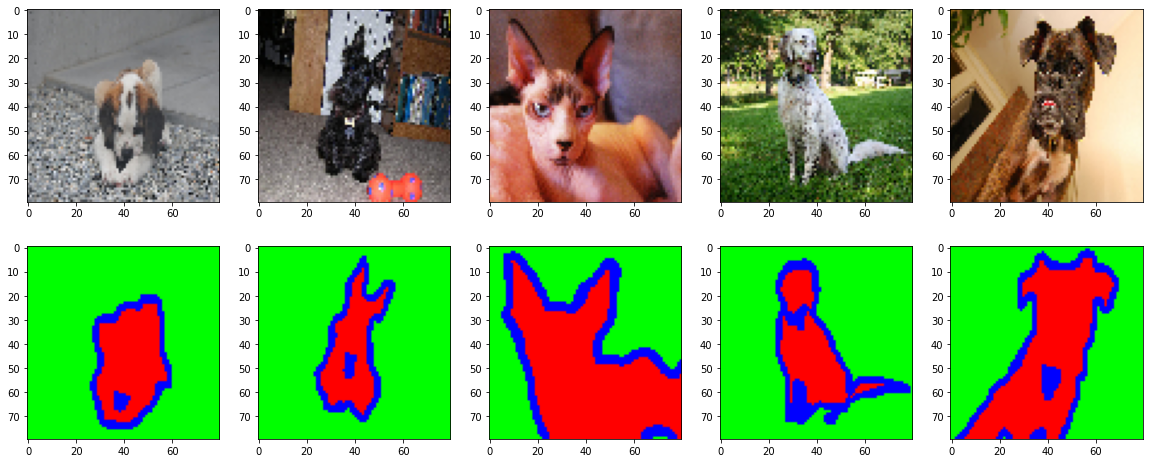

In [0]:
img2plot = 5

img2plot = np.min([img2plot,x_train.shape[0]])

fig = plt.figure(figsize=(4*img2plot,8))

for i in range(img2plot):
  
  # Image
  plt.subplot(2,img2plot,i+1)
  plt.imshow(x_train[i])

  # Segmentation
  plt.subplot(2,img2plot,img2plot+i+1)
  plt.imshow(y_train[i])

plt.show()

# Modello

Advanced activation functions @ https://keras.io/layers/advanced-activations/

In [0]:
img_shape = x_train[0].shape

## Compile model

In [0]:
from tensorflow.keras import layers, models, losses

In [0]:
# Parameteri del modello
num_filtri = 20
kernel_dim = (5,5)
pool_dim = (2,2)

#padding_type = 'valid'
padding_type = 'same'

activation_type = 'relu'
leaky_relu_alpha = 0

# Create net
net = models.Sequential()

# Encoder
net.add(layers.Conv2D(num_filtri, kernel_dim, strides=1, padding=padding_type, input_shape=img_shape, name='CONV1'))
net.add(layers.LeakyReLU(alpha=leaky_relu_alpha))

net.add(layers.MaxPooling2D(pool_dim, strides=2))

net.add(layers.Conv2D(num_filtri*2, kernel_dim, padding=padding_type))
net.add(layers.LeakyReLU(alpha=leaky_relu_alpha))

net.add(layers.MaxPooling2D(pool_dim,strides=2))

net.add(layers.Conv2D(num_filtri*2, kernel_dim, strides=1, padding=padding_type))
net.add(layers.LeakyReLU(alpha=leaky_relu_alpha))

net.add(layers.MaxPooling2D(pool_dim,strides=2))

net.add(layers.Conv2D(num_filtri*2, kernel_dim, strides=1, padding=padding_type))
net.add(layers.LeakyReLU(alpha=leaky_relu_alpha))

# Decoder 

net.add(layers.UpSampling2D(size=(2, 2),interpolation='bilinear'))

net.add(layers.Conv2DTranspose(num_filtri*2,kernel_dim, strides=2, padding=padding_type))
net.add(layers.LeakyReLU(alpha=leaky_relu_alpha))

net.add(layers.UpSampling2D(size=(2, 2),interpolation='bilinear', name='CONV2'))


#net.add(layers.concatenate(axis=-1, inputs=net.get_layer('CONV2'), net.get_layer('CONV1')))
#This is not going to work this way, you are mixing Sequential and Functional APIs, you have to implement this only with the Functional API

net.add(layers.Conv2DTranspose(3,kernel_dim, strides=1, padding=padding_type, activation='softmax'))

# Compile net
net.compile(optimizer='adam',
            loss=losses.categorical_crossentropy,
            metrics=['accuracy'])

# Explain net
net.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
CONV1 (Conv2D)               (None, 80, 80, 20)        1520      
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 80, 80, 20)        0         
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 40, 40, 20)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 40, 40, 40)        20040     
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 40, 40, 40)        0         
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 20, 20, 40)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 20, 20, 40)       

## Define plotting function

In [0]:
def plot_images(img2plot=5, choose_random=True):

  # Set plotting parameters
  test_set_dimension = x_test.shape[0]

  # Create shuffled index to take random pictures
  pic_index = np.arange(test_set_dimension)

  # Controlla se eseguire un random shuffle delle immagini
  if choose_random:
    np.random.shuffle(pic_index)

  # Fix out of bound issues
  img2plot = np.min([img2plot,test_set_dimension])

  # Perform pixel-wise classification
  to_predict = x_test[pic_index[:img2plot+1]]
  predicted = net.predict(to_predict)

  # Define plot parameters if display row-wise or col-wise
  def disp_param(i=0):

    if img2plot<3:

      # display row-wise
      return (9, 3*img2plot), (img2plot, 3), 3*i+1, 3*i+2, 3*i+3
    
    else:

      # display column-wise
      return (3*img2plot, 9), (3, img2plot), i+1, img2plot+i+1, 2*img2plot+i+1

  if img2plot>0:

    # Define pictures
    fig = plt.figure(figsize=disp_param()[0])

    # Plot and subplot for each picture
    for i in range(img2plot):
      
      # Image
      plt.subplot(disp_param()[1][0],disp_param()[1][1],disp_param(i)[2])
      plt.imshow(x_test[pic_index[i]])

      # Segmentation
      plt.subplot(disp_param()[1][0],disp_param()[1][1],disp_param(i)[3])
      plt.imshow(y_test[pic_index[i]])

      # Predicted segmentation
      plt.subplot(disp_param()[1][0],disp_param()[1][1],disp_param(i)[4])
      plt.imshow(predicted[i])

    # Finally show plot
    plt.show()

  # return values to memorize improvements
  return x_test[pic_index[0]],y_test[pic_index[0]],predicted[0]

Plot some images and classification by the untrained model


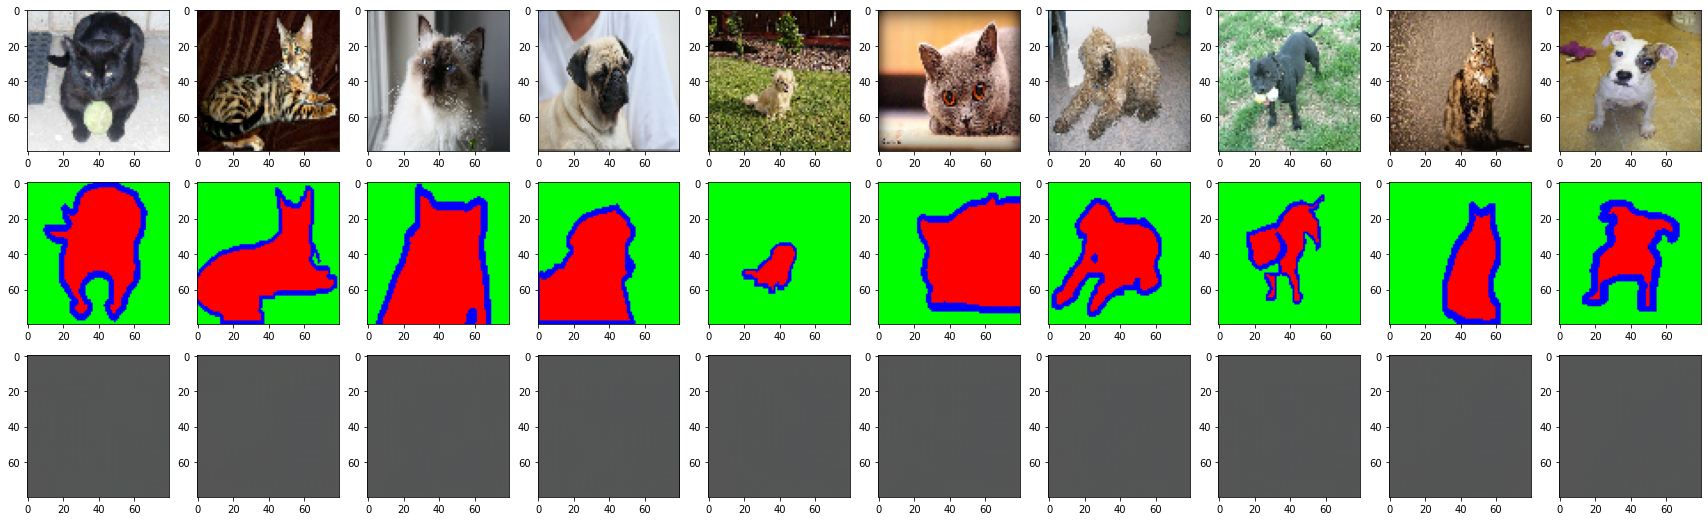

In [0]:
print('Plot some images and classification by the untrained model')
_ = plot_images(img2plot=10, choose_random=True)

## Define custom callback

In [0]:
# Initialize epoch vector to memorize improvements
epoch_x_test = []
epoch_y_test = []
epoch_predct = []

img2plot = 0

from IPython.display import clear_output

class DisplayCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):

    # clear cell 
    if img2plot>0:

      clear_output(wait=True)
      print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

    # Execute prediction and plotting
    a,b,c = plot_images(img2plot,choose_random=False)

    epoch_x_test.append(a)
    epoch_y_test.append(b)
    epoch_predct.append(c)

## Train model

In [0]:
# Train
batch_size_value = 32
max_epochs_value = 250

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.005, patience=6, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

reduceLr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, mode='auto', min_delta=0.0010, cooldown=0, min_lr=0)

history = net.fit(x_train, y_train,
                  batch_size = batch_size_value,
                  epochs = max_epochs_value,
                  validation_data = (x_test, y_test),
                  shuffle = True,
                  #callbacks=[DisplayCallback(), early_stopping, reduceLr],
                  callbacks=[early_stopping, reduceLr],
                  verbose=1
                  )

Train on 1191 samples, validate on 805 samples
Epoch 1/250
1191/1191 [==============================] - 41s 35ms/step - loss: 0.8566 - acc: 0.6525 - val_loss: 0.7992 - val_acc: 0.6887
Epoch 2/250
1191/1191 [==============================] - 41s 34ms/step - loss: 0.7634 - acc: 0.6971 - val_loss: 0.7589 - val_acc: 0.6977
Epoch 3/250
1191/1191 [==============================] - 41s 35ms/step - loss: 0.7491 - acc: 0.7030 - val_loss: 0.7253 - val_acc: 0.7109
Epoch 4/250
1191/1191 [==============================] - 41s 35ms/step - loss: 0.7282 - acc: 0.7098 - val_loss: 0.7189 - val_acc: 0.7150
Epoch 5/250
1191/1191 [==============================] - 41s 34ms/step - loss: 0.7077 - acc: 0.7196 - val_loss: 0.6951 - val_acc: 0.7232
Epoch 6/250
1191/1191 [==============================] - 40s 34ms/step - loss: 0.6668 - acc: 0.7336 - val_loss: 0.6841 - val_acc: 0.7272
Epoch 7/250
1191/1191 [==============================] - 40s 34ms/step - loss: 0.6468 - acc: 0.7413 - val_loss: 0.6449 - val_acc: 0

## Metrics

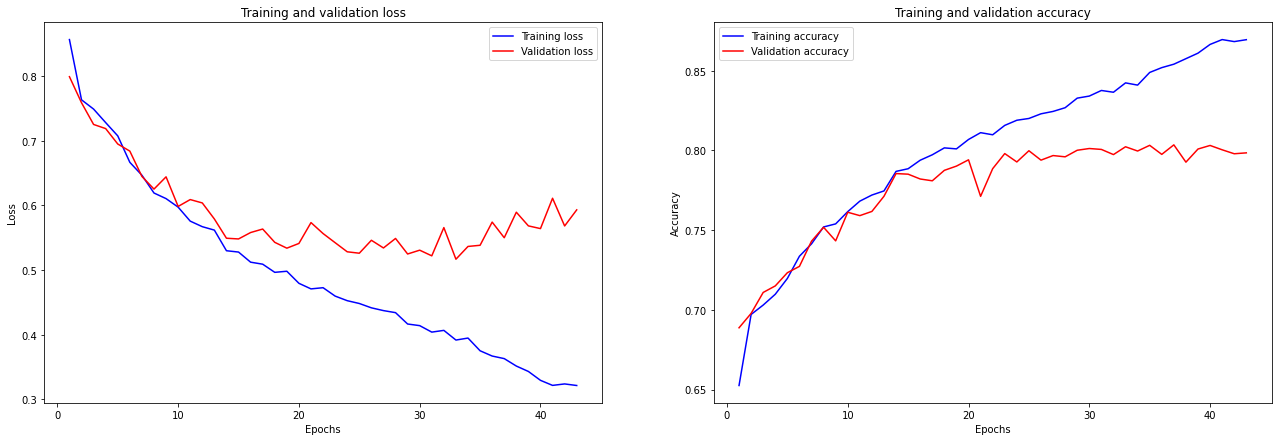

In [0]:
# Plot Loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.figure(figsize=(22,7))

plt.subplot(1,2,1)
plt.plot(epochs, loss, '-b', label='Training loss')
plt.plot(epochs, val_loss, '-r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


# Plot accuracy
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.subplot(1,2,2)
plt.plot(epochs, acc, '-b', label='Training accuracy')
plt.plot(epochs, val_acc, '-r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Export model weights

In [0]:
net_parameters = 'Relu'

In [0]:
net.save('/gdrive/My Drive/ML & AI/Colab/Model_weights/cnn_segmentation_'+net_parameters+'.h5')

## Load old model

In [0]:
from keras.models import load_model

In [0]:
net_parameters = 'Lrelu'

In [0]:
net = load_model('/gdrive/My Drive/ML & AI/Colab/Model_weights/cnn_segmentation_'+net_parameters+'.h5')

## Trained net behaviour on test set

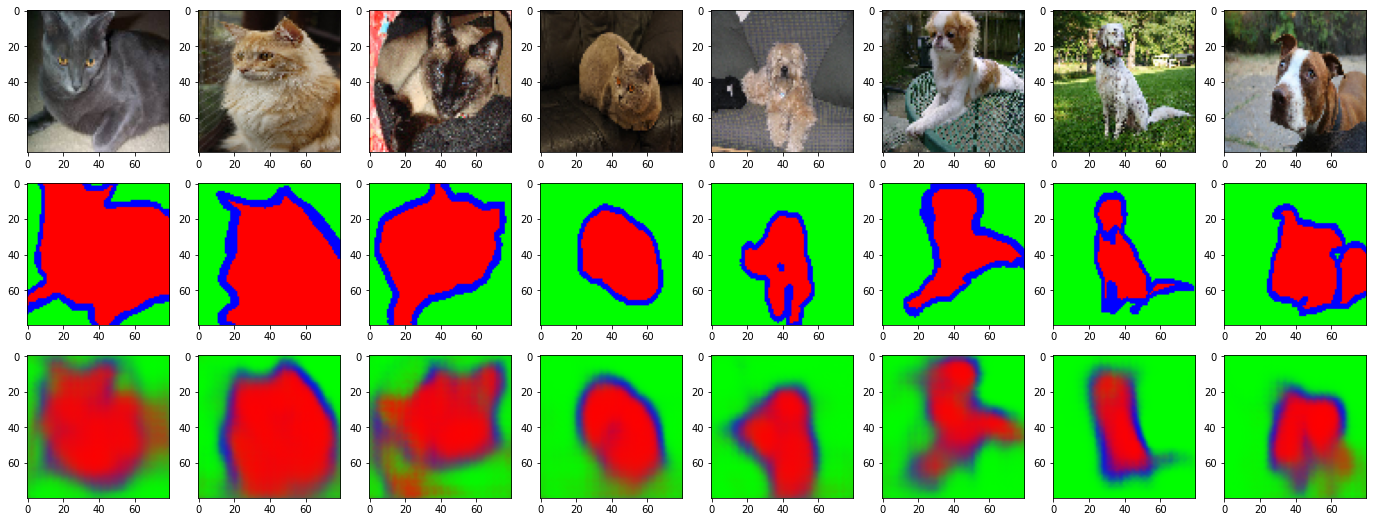

In [0]:
_ = plot_images(img2plot=8, choose_random=True)

# Export gif

In [0]:
for i in range(np.shape(epoch_predct)[0]):

  epoch_predct[i] = np.asarray(epoch_predct[i]*255).astype('uint8')

In [0]:
import os
import imageio

imageio.mimsave('/content/dataset_directory/movie.gif', epoch_predct, format='GIF', duration=0.2)

# Intermediate hidden representation

In [0]:
# Extract layers from model
successive_outputs = [layer.output for layer in net.layers]

# Extract layer names
layer_names = [layer.name for layer in net.layers]

# Build new multi-output model: visualization_model = Model(img_input, successive_outputs)
visualization_model = keras.models.Model(inputs = net.input, outputs = successive_outputs)

In [0]:
image_index = 1
img_to_plot = x_test[image_index]


successive_feature_maps = visualization_model.predict(np.expand_dims(img_to_plot, axis=0))

plt.figure(figsize=(img_dimension/7,img_dimension/21))

plt.subplot(1,3,1)
plt.imshow(img_to_plot, aspect='auto')

plt.subplot(1,3,2)
plt.imshow(y_test[image_index], aspect='auto')

plt.subplot(1,3,3)
plt.imshow(successive_feature_maps[-1][0], aspect='auto')

plt.show()

conv_cmap = 'viridis'

for layer_name, feature_map in zip(layer_names, successive_feature_maps):

    repeat_layer_name = 1
    print('\n'*3+(' > Layer name: '+str(layer_name)+' - feature_map_shape: '+str((feature_map.shape))+' - num_filtri: '+str((feature_map.shape[-1]))+'\t\t\t')*repeat_layer_name)
    
    # conv / maxpool layers: the feature map has 4 dimensions: (batch, row_size, col_size, filtri)
    if len(feature_map.shape) == 4:

      # Extract informations

      row_size = feature_map.shape[1] #row
      col_size = feature_map.shape[2] #col
      n_filtri = feature_map.shape[3] #numero filtri (num kernel)

      # We will tile our images in this matrix
      display_grid = np.zeros((row_size, col_size * n_filtri))

      for kernel in range(n_filtri):

        image_batch_num = 0 # passo una sola immagine per volta, quindi indice 0

        x = feature_map[image_batch_num, :, :, kernel]

        x = (x-x.min())/(x.max()-x.min()+0.00000001)

        # We'll tile each filter into this big horizontal grid
        display_grid[:, kernel * col_size : (kernel + 1) * col_size] = x

      # Display the grid
      scale = 5
      plt.figure(figsize=(scale * n_filtri, scale))
      plt.title(layer_name)
      plt.grid(False)
      plt.imshow(display_grid, aspect='auto', cmap=conv_cmap)
      plt.colorbar()
      plt.show()


# Perform prediction on modified test images

In [0]:
import scipy

In [0]:
# choose image
img_index = list(np.arange(20,25))

## Rotation

In [0]:
# define rotation angle
angle = 90

# define number of pictures to plot
pic_x_row = 6
num_img = len(img_index)

# define figure
plt.figure(figsize=(5*num_test,5*num_img))

for i, img_idx in enumerate(img_index):

  # select image from test set
  img_to_plot = x_test[img_idx]

  # plain prediction (0 degrees)
  predicted_plain = net.predict(np.expand_dims(img_to_plot, axis=0))[0]

  # prediction on 1st rotation (90 degrees)
  predicted_angle_1 = scipy.ndimage.rotate(img_to_plot, angle)
  predicted_angle_1 = net.predict(np.expand_dims(predicted_angle_1, axis=0))
  predicted_angle_1 = scipy.ndimage.rotate(predicted_angle_1[0], -angle)

  # prediction on 2nd rotation (180 degrees)
  predicted_angle_2 = scipy.ndimage.rotate(img_to_plot, 2*angle)
  predicted_angle_2 = net.predict(np.expand_dims(predicted_angle_2, axis=0))
  predicted_angle_2 = scipy.ndimage.rotate(predicted_angle_2[0], -2*angle)

  # prediction on 3rd rotation (270 degrees)
  predicted_angle_3 = scipy.ndimage.rotate(img_to_plot, 3*angle)
  predicted_angle_3 = net.predict(np.expand_dims(predicted_angle_3, axis=0))
  predicted_angle_3 = scipy.ndimage.rotate(predicted_angle_3[0], -3*angle)

  # Fill each subplot
  plt.subplot(num_img, pic_x_row, i*pic_x_row + 1)
  plt.imshow(img_to_plot, aspect='auto')
  plt.title('input_image')

  plt.subplot(num_img, pic_x_row, i*pic_x_row + 2)
  plt.imshow(y_test[img_idx], aspect='auto')
  plt.title('ground_truth')

  plt.subplot(num_img, pic_x_row, i*pic_x_row + 3)
  plt.imshow(predicted_plain, aspect='auto')
  plt.title('rotate_by'+str(0))

  plt.subplot(num_img, pic_x_row, i*pic_x_row + 4)
  plt.imshow(predicted_angle_1, aspect='auto')
  plt.title('rotate_by'+str(angle))

  plt.subplot(num_img, pic_x_row, i*pic_x_row + 5)
  plt.imshow(predicted_angle_2, aspect='auto')
  plt.title('rotate_by'+str(2*angle))

  plt.subplot(num_img, pic_x_row, i*pic_x_row + 6)
  plt.imshow(predicted_angle_3, aspect='auto')
  plt.title('rotate_by'+str(3*angle))

plt.show()

## Color alteration

### Noise

Altero i pixel secondo un valore random che mediamente non produce alterazioni sulla immagine complessiva

In [0]:
# define number of pictures to plot
pic_x_row = 5
num_img = len(img_index)

alpha_mix = 0.4

# define figure
plt.figure(figsize=(5*pic_x_row,5*num_img))

for i, img_idx in enumerate(img_index):

  # select image from test set
  img_to_plot = x_test[img_idx]

  # no alteration
  predicted_alter0 = net.predict(np.expand_dims(img_to_plot, axis=0))[0]

  # first alteration
  pic_alter_1 = 1+2*(np.random.random_sample(img_to_plot.shape)-0.5)
  pic_alter_1 = np.clip((1-alpha_mix)*img_to_plot + alpha_mix*pic_alter_1, 0, 1)

  predicted_alter1 = net.predict(np.expand_dims(pic_alter_1, axis=0))[0]

  # Fill each subplot
  plt.subplot(num_img, pic_x_row, pic_x_row*i + 1)
  plt.imshow(img_to_plot, aspect='auto')
  plt.title('input_image')

  plt.subplot(num_img, pic_x_row, pic_x_row*i + 2)
  plt.imshow(pic_alter_1, aspect='auto')
  plt.title('altered_image_alpha='+str(alpha_mix))

  plt.subplot(num_img, pic_x_row, pic_x_row*i + 3)
  plt.imshow(y_test[img_idx], aspect='auto')
  plt.title('ground_truth')

  plt.subplot(num_img, pic_x_row, pic_x_row*i + 4)
  plt.imshow(predicted_alter0, aspect='auto')
  plt.title('pred_no_alteration')

  plt.subplot(num_img, pic_x_row, pic_x_row*i + 5)
  plt.imshow(predicted_alter1, aspect='auto')
  plt.title('pred_alteration_alpha='+str(alpha_mix))

plt.show()

### Alter pixel plus brightness

In [0]:
# define number of pictures to plot
pic_x_row = 5
num_img = len(img_index)

# define figure
plt.figure(figsize=(5*pic_x_row,5*num_img))

for i, img_idx in enumerate(img_index):

  # select image from test set
  img_to_plot = x_test[img_idx]

  # no alteration
  predicted_alter0 = net.predict(np.expand_dims(img_to_plot, axis=0))[0]

  # first alteration
  pic_alter_1 = 2+2*(np.random.random_sample(img_to_plot.shape)-0.5)
  pic_alter_1 = np.clip(img_to_plot*pic_alter_1, 0, 1)

  predicted_alter1 = net.predict(np.expand_dims(pic_alter_1, axis=0))[0]

  # Fill each subplot
  plt.subplot(num_img, pic_x_row, pic_x_row*i + 1)
  plt.imshow(img_to_plot, aspect='auto')
  plt.title('input_image')

  plt.subplot(num_img, pic_x_row, pic_x_row*i + 2)
  plt.imshow(pic_alter_1, aspect='auto')
  plt.title('altered_image')

  plt.subplot(num_img, pic_x_row, pic_x_row*i + 3)
  plt.imshow(y_test[img_idx], aspect='auto')
  plt.title('ground_truth')

  plt.subplot(num_img, pic_x_row, pic_x_row*i + 4)
  plt.imshow(predicted_alter0, aspect='auto')
  plt.title('pred_no_alteration')

  plt.subplot(num_img, pic_x_row, pic_x_row*i + 5)
  plt.imshow(predicted_alter1, aspect='auto')
  plt.title('pred_alteration_1')

plt.show()

### Alter pixel / Reduce brightness

In [0]:
# define number of pictures to plot
pic_x_row = 5
num_img = len(img_index)

# define figure
plt.figure(figsize=(5*pic_x_row,5*num_img))

for i, img_idx in enumerate(img_index):

  # select image from test set
  img_to_plot = x_test[img_idx]

  # no alteration
  predicted_alter0 = net.predict(np.expand_dims(img_to_plot, axis=0))[0]

  # first alteration
  pic_alter_1 = 0+2*(np.random.random_sample(img_to_plot.shape)-0.5)
  pic_alter_1 = np.clip(img_to_plot*pic_alter_1, 0, 1)

  predicted_alter1 = net.predict(np.expand_dims(pic_alter_1, axis=0))[0]

  # Fill each subplot
  plt.subplot(num_img, pic_x_row, pic_x_row*i + 1)
  plt.imshow(img_to_plot, aspect='auto')
  plt.title('input_image')

  plt.subplot(num_img, pic_x_row, pic_x_row*i + 2)
  plt.imshow(pic_alter_1, aspect='auto')
  plt.title('altered_image')

  plt.subplot(num_img, pic_x_row, pic_x_row*i + 3)
  plt.imshow(y_test[img_idx], aspect='auto')
  plt.title('ground_truth')

  plt.subplot(num_img, pic_x_row, pic_x_row*i + 4)
  plt.imshow(predicted_alter0, aspect='auto')
  plt.title('pred_no_alteration')

  plt.subplot(num_img, pic_x_row, pic_x_row*i + 5)
  plt.imshow(predicted_alter1, aspect='auto')
  plt.title('pred_alteration_1')

plt.show()

### Alter color

In [0]:
# define number of pictures to plot
pic_x_row = 5
num_img = len(img_index)

for channel in range(3):

  # define figure
  plt.figure(figsize=(5*pic_x_row,5*num_img))

  for i, img_idx in enumerate(img_index):

    # select image from test set
    img_to_plot = x_test[img_idx]

    # no alteration
    predicted_alter0 = net.predict(np.expand_dims(img_to_plot, axis=0))[0]

    # first alteration
    pic_alter_1 = np.zeros(img_to_plot.shape)
    pic_alter_1[:,:,channel] = 1
    pic_alter_1 = np.clip(img_to_plot*pic_alter_1, 0, 1)

    predicted_alter1 = net.predict(np.expand_dims(pic_alter_1, axis=0))[0]

    # Fill each subplot
    plt.subplot(num_img, pic_x_row, pic_x_row*i + 1)
    plt.imshow(img_to_plot, aspect='auto')
    plt.title('input_image')

    plt.subplot(num_img, pic_x_row, pic_x_row*i + 2)
    plt.imshow(pic_alter_1, aspect='auto')
    plt.title('altered_image')

    plt.subplot(num_img, pic_x_row, pic_x_row*i + 3)
    plt.imshow(y_test[img_idx], aspect='auto')
    plt.title('ground_truth')

    plt.subplot(num_img, pic_x_row, pic_x_row*i + 4)
    plt.imshow(predicted_alter0, aspect='auto')
    plt.title('pred_no_alteration')

    plt.subplot(num_img, pic_x_row, pic_x_row*i + 5)
    plt.imshow(predicted_alter1, aspect='auto')
    plt.title('pred_alteration_1')

  plt.show()

  print('\n'*3)

### Color Gradient along different directions

In [0]:
# define gradient vector
color_gradient = np.zeros(x_test[0].shape)

In [0]:
# Fill each channel with different gradient

# channel R
a, b = np.mgrid[0:img_dimension, 0:img_dimension]
color_gradient[:,:,0] = (a+b)/(2*img_dimension-2)

# channel G
a, b = np.mgrid[img_dimension:0:-1, 0:img_dimension]
color_gradient[:,:,1] = (a+b)/(img_dimension)

# channel B
a, b = np.mgrid[img_dimension:0:-1, img_dimension:0:-1]
color_gradient[:,:,2] = (a+b)/(2*img_dimension)

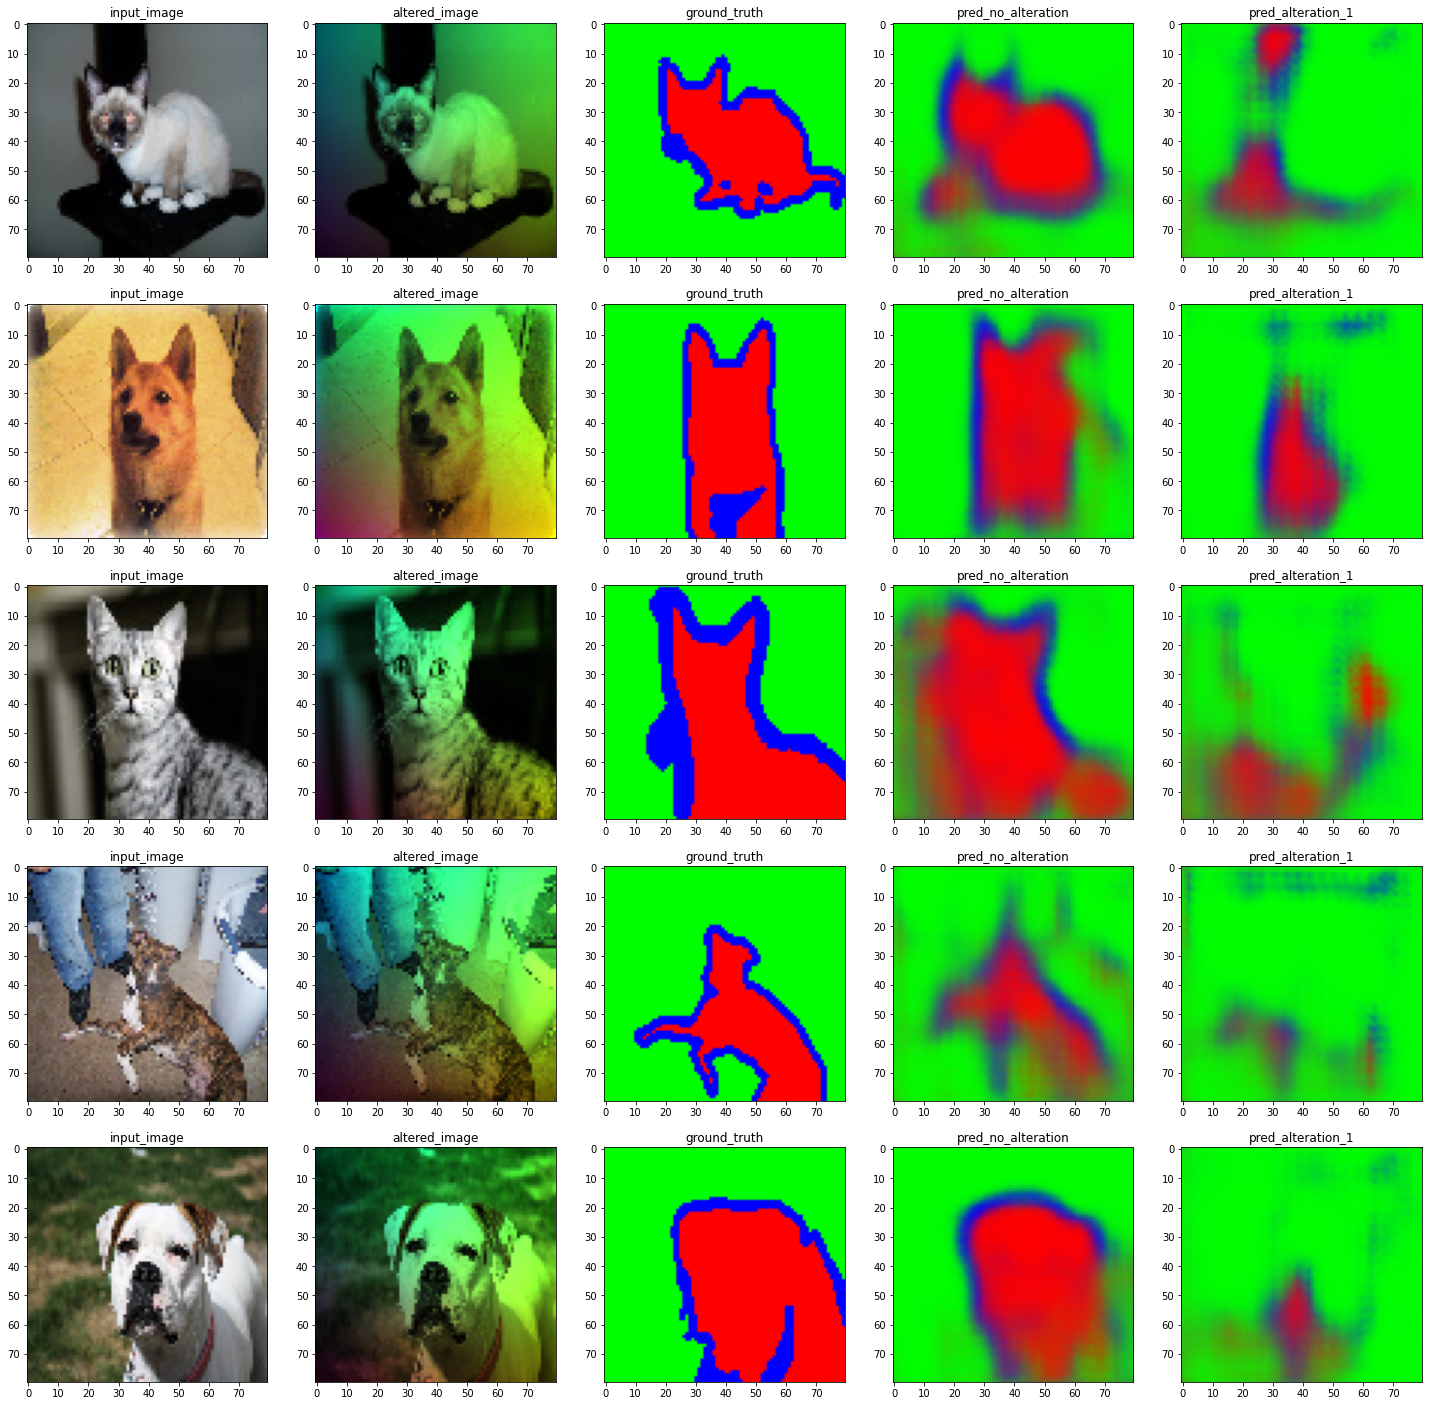

In [0]:
plt.figure(figsize=(5*pic_x_row,5*num_img))

for i, img_idx in enumerate(img_index):

  # select image from test set
  img_to_plot = x_test[img_idx]

  # no alteration
  predicted_alter0 = net.predict(np.expand_dims(img_to_plot, axis=0))[0]

  # first alteration
  pic_alter_1 = np.clip(img_to_plot*color_gradient, 0, 1)

  predicted_alter1 = net.predict(np.expand_dims(pic_alter_1, axis=0))[0]

  # Fill each subplot
  plt.subplot(num_img, pic_x_row, pic_x_row*i + 1)
  plt.imshow(img_to_plot, aspect='auto')
  plt.title('input_image')

  plt.subplot(num_img, pic_x_row, pic_x_row*i + 2)
  plt.imshow(pic_alter_1, aspect='auto')
  plt.title('altered_image')

  plt.subplot(num_img, pic_x_row, pic_x_row*i + 3)
  plt.imshow(y_test[img_idx], aspect='auto')
  plt.title('ground_truth')

  plt.subplot(num_img, pic_x_row, pic_x_row*i + 4)
  plt.imshow(predicted_alter0, aspect='auto')
  plt.title('pred_no_alteration')

  plt.subplot(num_img, pic_x_row, pic_x_row*i + 5)
  plt.imshow(predicted_alter1, aspect='auto')
  plt.title('pred_alteration_1')

plt.show()